# Fitting
In this notebook, I'll show how to use `Korg.Fit.fit_spectrum` to fit one of the spectra from [Griffith et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv221001821G). You will probably find it helpful to look at the [documentation for this function](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.Fit.fit_spectrum) as well. For fitting equivalent widths (rather than spectra directly) see [the documentation for `Korg.Fit.ews_to_abundances`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.Fit.ews_to_abundances).

This notebook is intended to demonstrate the usages of Korg's fitting functionality, not an ironclad spectral analysis.

We'll use a few packages in addition to Korg in this notebook.  If don't have them installed, you can run `using Pkg; Pkg.add(["CSV", "DataFrames", "PyPlot"])` to install them.

In [6]:
using Korg, CSV, DataFrames, PyPlot

## Read in the linelist, window list, and spectrum

For this example, we'll use the same linelist and windows as Griffith et al. 2022, which means reading the CSV files they are stored in and getting the data into the format expected by Korg. For other linelists options, see the documentation for [Korg's built-in linelists](https://ajwheeler.github.io/Korg.jl/stable/API/#Built-in-linelists), and [`Korg.read_linelist`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.read_linelist).

In [2]:
# read and parse the linelist used by Griffith et al. 2022
linetable = CSV.read("lines.csv", DataFrame);
linelist = Korg.Line.(Korg.air_to_vacuum.(linetable.wave_A),
                      linetable.loggf,
                      Korg.Species.(linetable.element),
                      linetable.lower_state_eV,
                      linetable.rad, 
                      linetable.stark, 
                      linetable.waals) 
;

In [3]:
# read windows into dictionary that maps atomic number -> window list
windowtable = CSV.File("windows.tsv", delim='\t');
windows = Dict()
for row in windowtable
    # atomic number
    Z = Korg.get_atoms(Korg.Species(row.species))[1]
    # get the windows for this element so far 
    wins = get(windows, Z, [])
    # add the new window
    push!(wins, (Korg.air_to_vacuum(row.wave_base * 10), Korg.air_to_vacuum(row.wave_top * 10)))
    # update the dictionary
    windows[Z] = wins
end

In [4]:
# parse the observed spectrum
spec = CSV.read("2MASS_J03443498+0553014.csv", DataFrame)
spec.waveobs = Korg.air_to_vacuum.(spec.waveobs * 10)
;

# Get stellar params with just Fe lines
First, we'll use the Fe windows from `windows.tsv` to fit for the stellar parameters. You may notice that the first time you run this, the `@time` macro reports a high fraction of time spent compiling.  This happens only once per session. 

In [5]:
# provide an initial guess for each parameter we want to fit
# (This is how to construct a NamedTuple in Julia, by the way.)
initial_guess = (;Teff=5400, logg=3.8, m_H=-1.1, vmic=1.0)
winds = windows[26] # use Fe windows

@time fit_result = Korg.Fit.fit_spectrum(spec.waveobs, spec.flux, spec.err, linelist, initial_guess; windows=winds, R=50_000)
;

Constructing cool dwarf atmosphere interpolator.  This will only happen once per process...
134.671266 seconds (1.50 G allocations: 93.451 GiB, 9.43% gc time, 77.34% compilation time: <1% of which was recompilation)


`fit_result` is an object containing several bits of info, most importantly the best-fit parameters

In [6]:
fit_result.best_fit_params

Dict{String, Float64} with 4 entries:
  "Teff" => 5250.17
  "logg" => 3.68018
  "m_H"  => -1.33611
  "vmic" => 0.80091

It also contains the trace, which we can plot like so

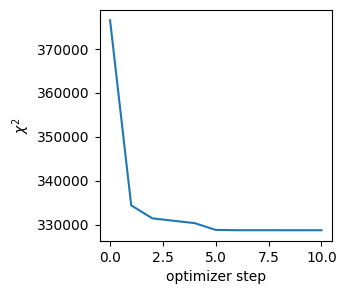

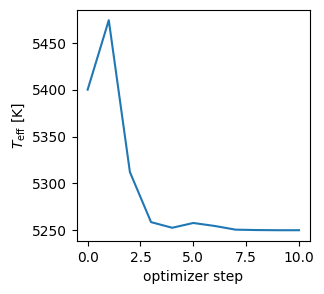

In [7]:
figure(figsize=(3,3))
plot([t["chi2"] for t in fit_result.trace])
ylabel(L"χ^2")
xlabel("optimizer step")

figure(figsize=(3,3))
plot([t["Teff"] for t in fit_result.trace])
ylabel(L"$T_\mathrm{eff}$ [K]")
xlabel("optimizer step")
;

The `fit_result` object also contains the best-fit spectrum, which we can plot in comparision to the oberved one.  Rerun the cell below to plot data for different iron lines.

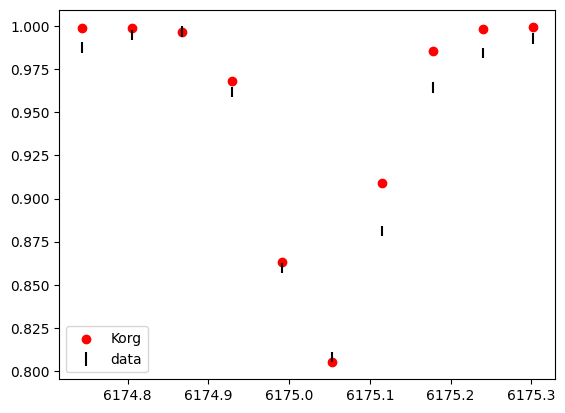

PyObject <matplotlib.legend.Legend object at 0x354d908f0>

In [8]:
# get the observed spectrum only at the wavelengths within a fitting window
obs_wls = spec.waveobs[fit_result.obs_wl_mask]
obs_flux = spec.flux[fit_result.obs_wl_mask]
obs_err = spec.err[fit_result.obs_wl_mask]

w = rand(winds) # choose a window around a random Fe line

# create a bitmask to plot the window plus 1 Å on each side for context
mask = w[1]-1 .< obs_wls .< w[2]+1 

scatter(obs_wls[mask], fit_result.best_fit_flux[mask], c="r", label="Korg")
errorbar(obs_wls[mask], obs_flux[mask], yerr=obs_err[mask], ls="", c="k", label="data")
legend()

# Fit individual abundances

Let's use the stellar parameters from Griffith, rather than the ones from the analysis above. Comparing the abundances you get using each is left as an excercise to the reader.

In [9]:
griffith_params = (Teff = 5456, logg = 3.86, m_H = -1.22, vsini = 2.4, vmic=1.23)
println(fit_result.best_fit_params)
println(griffith_params)

Dict("Teff" => 5250.16592067555, "logg" => 3.6801815930457735, "m_H" => -1.336108181629835, "vmic" => 0.800910430599838)
(Teff = 5456, logg = 3.86, m_H = -1.22, vsini = 2.4, vmic = 1.23)


# find individual abundances

In [10]:
elements = ["Na", "Mg", "Si", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni"];
Korg_abunds = map(elements) do element
    println("fitting $(element)...")
        
    # use a Dict to store initial guesses at each param instead of a NamedTuple
    params = Dict(element=>griffith_params.m_H)

    # "params" specifies the initial guesses at the params to fit (in this case a single elemental abundance).
    # griffith_params specifies values which should be fixed (in this case the stellar parameters).
    @time fit_result = Korg.Fit.fit_spectrum(spec.waveobs, spec.flux, spec.err, linelist, 
                                  params, griffith_params;
                                  R=50_000, windows=windows[Korg.atomic_numbers[element]])

    # return the best-fit abundance
    fit_result.best_fit_params[element]
end
;

fitting Na...
 44.193333 seconds (781.58 M allocations: 34.463 GiB, 12.66% gc time, 92.76% compilation time)
fitting Mg...
  3.159460 seconds (115.07 M allocations: 6.654 GiB, 8.37% gc time, 9.26% compilation time)
fitting Si...
  4.036045 seconds (210.96 M allocations: 8.128 GiB, 8.34% gc time)
fitting Ca...
  4.757307 seconds (270.62 M allocations: 9.091 GiB, 8.44% gc time)
fitting Sc...
  3.590364 seconds (153.31 M allocations: 7.895 GiB, 9.04% gc time, 1.02% compilation time)
fitting Ti...
  8.397335 seconds (577.20 M allocations: 14.369 GiB, 7.92% gc time)
fitting V...
  4.037513 seconds (209.01 M allocations: 8.097 GiB, 9.17% gc time)
fitting Cr...
  5.091021 seconds (321.02 M allocations: 9.248 GiB, 8.27% gc time)
fitting Mn...
  5.954645 seconds (327.07 M allocations: 11.803 GiB, 8.68% gc time)
fitting Fe...
 19.004240 seconds (1.43 G allocations: 28.083 GiB, 7.80% gc time)
fitting Co...
  3.133594 seconds (127.66 M allocations: 6.893 GiB, 8.57% gc time)
fitting Ni...
  6.59752

Let's plot these in comparison to the Griffith et al. 2022 abundaces.

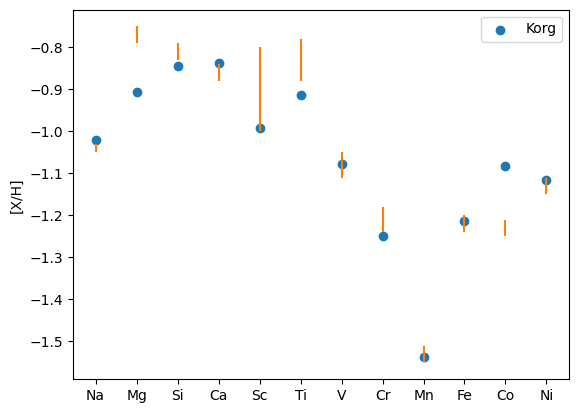

In [11]:
# The are the [X/H] values from the paper (and the errors inferred from Monte-Carlo)
griffith_X_H = [-1.04, -0.77, -0.81, -0.86, -0.9, -0.83, -1.08, -1.21, -1.53, -1.22, -1.23, -1.13]
griffith_X_H_err = [0.01, 0.02, 0.02, 0.02, 0.1, 0.05, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02]

scatter(1:length(elements), Korg_abunds, label="Korg")
errorbar(1:length(elements), griffith_X_H, yerr=griffith_X_H_err, ls="", c="C1")
xticks(1:length(elements), elements)
ylabel("[X/H]")
legend()
;